In [3]:
import numpy as np
import sys

# define a function to calculate ACSFs for a bunch of geoms

def clusers_ACSF(ClustersGeom):
    # ACSF parameters
    Rc0 = 6.0 # cut-off radius
    par_g2 = [[1, 1], [1, 2], [1, 3]] # eta, Rs
    par_g3 = [] # kappa
    par_g4 = [[1, 1, 1], [1, 2, 1], [1, 1, -1], [1, 2, -1]] # eta, zeta, lambda
    par_g5 = [] # eta, zeta, lambda

    # End settings

    # prepare ACSF paramters
    eta2 = []
    Rs = []
    kappa = []
    eta4 = []
    zeta4 = []
    lmbd4 = []
    eta5 = []
    zeta5 = []
    lmbd5 = []

    for ii in par_g2:
        eta2.append(ii[0])
        Rs.append(ii[1])

    for ii in par_g3:
        kappa.append(ii)
    
    for ii in par_g4:
        eta4.append(ii[0])
        zeta4.append(ii[1])
        lmbd4.append(ii[2])
    
    for ii in par_g5:
        eta5.append(ii[0])
        zeta5.append(ii[1])
        lmbd5.append(ii[2])

    strucs = []
    struc = []
    with open(ClustersGeom, "r") as INPUT:
        for line in INPUT:
            line_sp = line.split()
            if len(line_sp) == 1:
                if len(struc) != 0:
                    strucs.append(struc)
                struc = []
            if len(line_sp) == 4:
                struc.append([line_sp[0], np.asarray([float(line_sp[1]), float(line_sp[2]), float(line_sp[3])])])
            
    strucs.append(struc)

    def fc(R, Rc=Rc0):
        if R <= Rc:
            return 0.5*(np.cos(np.pi*R/Rc) + 1.0)
        else:
            return 0
    
    # G2 radial function
    def G2_r(R, eta2, Rs):
        G2 = []
        if len(eta2) != len(Rs):
            print("Parameter dimensions do not match in G2_r!")
            sys.exit()
        for i in range(len(eta2)):
            G2.append(np.exp(-eta2[i]*(R - Rs[i])**2) * fc(R))
        return G2

    # G3 radial function
    def G3_r(R, kappa):
        G3 = []
        for i in range(len(kappa)):
            G3.append(np.cos(kappa[i] * R) * fc(R))
        return G3

    # G4 angular function
    def G4_r(eta4, zeta4, lmbd4, Rij, Rik, Rjk):
        if (len(eta4) != len(zeta4)) or (len(eta4) != len(lmbd4)) or (len(zeta4) != len(lmbd4)):
            print("Parameter dimensions do not match in G4_r!")
            sys.exit()
        cos_theta = 0.5 * (Rij**2 + Rik**2 - Rjk**2)/(Rij*Rik)
        G4 = []
        for i in range(len(eta4)):
            G4.append((2.0)**(1.0 - zeta4[i]) *(1.0 + lmbd4[i] * cos_theta)**zeta4[i] * \
                np.exp(-eta4[i]*(Rij**2 + Rik**2 + Rjk**2)) * fc(Rij) * \
                fc(Rik) * fc(Rjk))
        return G4

    # G5 angular function
    def G5_r(eta5, zeta5, lmbd5, Rij, Rik, Rjk):
        if (len(eta5) != len(zeta5)) or (len(eta5) != len(lmbd5)) or (len(zeta5) != len(lmbd5)):
            print("Parameter dimensions do not match in G5_r!")
            sys.exit()
        cos_theta = 0.5 * (Rij**2 + Rik**2 - Rjk**2)/(Rij*Rik)
        G5 = []
        for i in range(len(eta5)):
            G5.append((2.0)**(1.0 - zeta5[i]) *(1.0 + lmbd5[i] * cos_theta)**zeta5[i] * \
                np.exp(-eta5[i]*(Rij**2 + Rik**2)) * fc(Rij) * \
                fc(Rik))
        return G5

    # utility: calculate the distance between two atoms
    def dist(coord1, coord2):
        return np.linalg.norm(coord1 - coord2)

    # utility: adding two arrays
    def array_add(arr1, arr2):
        if len(arr1) != len(arr2):
            print("Input dimensions not match in array_add()!")
            sys.exit()
        sum = []
        for i in range(len(arr1)):
            sum.append(arr1[i] + arr2[i])
        return sum

    # calculate ACSCFs for each atom in all structures
    calc_g3 = True
    calc_g5 = True

    if len(kappa) == 0:
        calc_g3 = False

    if len(eta5) == 0:
        calc_g5 = False

    strucs_G = []

    for cluster in strucs:
        struc_G = []
        no_atoms = len(cluster)
        for i in range(no_atoms):
            G1 = 0
            G2 = [0 for ii in eta2]
            G3 = [0 for ii in kappa]
            G4 = [0 for ii in eta4]
            G5 = [0 for ii in eta5]
            for j in range(no_atoms):
                if j != i:
                    # calculate Rij
                    Rij = dist(cluster[i][1], cluster[j][1])
                    G1 += fc(Rij) # calculate G1
                    G2 = array_add(G2, G2_r(Rij, eta2, Rs)) # calculate G2
                    if calc_g3:
                        G3 = array_add(G3, G3_r(Rij, kappa)) # calculate G3 when necessary
                    for k in range(no_atoms):
                        if k != i and k !=j:
                        # calculate Rik, Rjk
                            Rik = dist(cluster[i][1], cluster[k][1])
                            Rjk = dist(cluster[j][1], cluster[k][1])
                            G4 = array_add(G4, G4_r(eta4, zeta4, lmbd4, Rij, Rik, Rjk)) # calculate G4
                            if calc_g5:
                                G5 = array_add(G5, G5_r(eta5, zeta5, lmbd5, Rij, Rik, Rjk))
            struc_G.append([cluster[i][0], np.concatenate([[G1], G2, G3, G4, G5])])
        strucs_G.append(struc_G)
        
    return strucs_G

In [18]:
# prepare 1000 training data points
import torch

MBE_1 = []
MBE_2 = []
MBE_3 = []
MBE_4 = []
with open("pentamer_randrand_train_1000-MBE.dat", "r") as Target:
    for line in Target:
        line_sp = line.split()
        if len(line_sp) == 1:
            line_next = Target.readline()
            line_next_sp = line_next.split()
            MBE_1.append(float(line_next_sp[0]))
            line_next = Target.readline()
            line_next_sp = line_next.split()
            MBE_2.append(float(line_next_sp[0]))
            line_next = Target.readline()
            line_next_sp = line_next.split()
            MBE_3.append(float(line_next_sp[0]))
            line_next = Target.readline()
            line_next_sp = line_next.split()
            MBE_4.append(float(line_next_sp[0]))

trans_mbe1_1000_train = [10*(e + 382.0) for e in MBE_1]
trans_mbe1_1000_train = torch.from_numpy(np.asarray(trans_mbe1_1000_train))
trans_mbe2_1000_train = [10*(e + 382.0) for e in MBE_2]
trans_mbe2_1000_train = torch.from_numpy(np.asarray(trans_mbe2_1000_train))
trans_mbe3_1000_train = [10*(e + 382.0) for e in MBE_3]
trans_mbe3_1000_train = torch.from_numpy(np.asarray(trans_mbe3_1000_train))
trans_mbe4_1000_train = [10*(e + 382.0) for e in MBE_4]
trans_mbe4_1000_train = torch.from_numpy(np.asarray(trans_mbe4_1000_train))

strucs_G_train_1000 = clusers_ACSF('randrand_5waters-1000-box5-train.xyz')

In [19]:
# prepare the testing reference data
MBE_1t = []
MBE_2t = []
MBE_3t = []
MBE_4t = []
with open("pentamer_W5_test_19-MBE.dat", "r") as Target:
    for line in Target:
        line_sp = line.split()
        if len(line_sp) == 1:
            line_next = Target.readline()
            line_next_sp = line_next.split()
            MBE_1t.append(float(line_next_sp[0]))
            line_next = Target.readline()
            line_next_sp = line_next.split()
            MBE_2t.append(float(line_next_sp[0]))
            line_next = Target.readline()
            line_next_sp = line_next.split()
            MBE_3t.append(float(line_next_sp[0]))
            line_next = Target.readline()
            line_next_sp = line_next.split()
            MBE_4t.append(float(line_next_sp[0]))

trans_mbe1_1000_test = [10*(e + 382.0) for e in MBE_1t]
trans_mbe1_1000_test = torch.from_numpy(np.asarray(trans_mbe1_1000_test))
trans_mbe2_1000_test = [10*(e + 382.0) for e in MBE_2t]
trans_mbe2_1000_test = torch.from_numpy(np.asarray(trans_mbe2_1000_test))
trans_mbe3_1000_test = [10*(e + 382.0) for e in MBE_3t]
trans_mbe3_1000_test = torch.from_numpy(np.asarray(trans_mbe3_1000_test))
trans_mbe4_1000_test = [10*(e + 382.0) for e in MBE_4t]
trans_mbe4_1000_test = torch.from_numpy(np.asarray(trans_mbe4_1000_test))

strucs_G_test = clusers_ACSF('W5_geoms_all.xyz')

In [55]:
MBE_2t, trans_mbe2_1000_test

([-382.096119848736,
  -382.096099675402,
  -382.09609126886,
  -382.10192083355,
  -382.098512147375,
  -382.09898762479,
  -382.100285487322,
  -382.100108146946,
  -382.101831783875,
  -382.099069365963,
  -382.098713522309,
  -382.093260187188,
  -382.090159322373,
  -382.090479814469,
  -382.096198202749,
  -382.095506585272,
  -382.09573079821,
  -382.096724403447,
  -382.096404900877],
 tensor([-0.9612, -0.9610, -0.9609, -1.0192, -0.9851, -0.9899, -1.0029, -1.0011,
         -1.0183, -0.9907, -0.9871, -0.9326, -0.9016, -0.9048, -0.9620, -0.9551,
         -0.9573, -0.9672, -0.9640]))

In [31]:
# Define the molecular cluster NN

import collections

torch.set_default_dtype(torch.float64)

# Settings
n_hiddens_H = 3
n_hiddens_O = 3
n_hidden_H = 32
n_hidden_O = 64
n_out_H = 1
n_out_O = 1
activation_H = 'sigmoid'
activation_O = 'sigmoid'

# End settings

no_atom_inputs = len(strucs_G[0][0][1])

class AtomicNet(torch.nn.Module):
    """A simple feed-forward network with variable structure, randomly
    initialized weights, choosable activation and a linear output layer.
    """
    def __init__(self, n_features, n_hiddens, n_hidden, n_out, activation):
        super(AtomicNet, self).__init__()
        self.n_hiddens = n_hiddens
        if activation.lower() == 'relu':
            self.activation = torch.nn.ReLU()
        elif activation.lower() == 'sigmoid': 
            self.activation = torch.nn.Sigmoid()
        elif activation.lower() == 'tanh': 
            self.activation = torch.nn.Tahn()
        else:
            print("Activation function not recoginized!")
            sys.exit(1)
        func_ordered_dict = collections.OrderedDict()
        func_ordered_dict['input'] = torch.nn.Linear(n_features, n_hidden)
        func_ordered_dict['act0'] = self.activation
        for i in range(n_hiddens):
            func_ordered_dict['hidden'+str(i+1)] = torch.nn.Linear(n_hidden, n_hidden)
            func_ordered_dict['act'+str(i+1)] = self.activation
        func_ordered_dict['out'] = torch.nn.Linear(n_hidden, n_out)
        self.linear_act_stack = torch.nn.Sequential(func_ordered_dict)

    def forward(self, x):
        x = self.linear_act_stack(x)
                                               
        return x

class ClusterModel(torch.nn.Module):
    def __init__(self, cluster):
        super(ClusterModel, self).__init__()
        self.cluster = cluster
        self.NN_H = AtomicNet(no_atom_inputs, n_hiddens_H, n_hidden_H, n_out_H, activation_H)
        self.NN_O = AtomicNet(no_atom_inputs, n_hiddens_O, n_hidden_O, n_out_O, activation_O)
#         self.NN_H = mymodel_mono.NN_H
#         self.NN_O = mymodel_mono.NN_O
        
    def forward(self, cluster):
        E_cluster = 0
        for atom in cluster:
#             ii_O = 0
            if atom[0] == 'O':
                G_O = torch.from_numpy(atom[1])
#                 E_O = self.NN_O(G_O)
                E_O = self.NN_O(G_O)/(-1000.0) - 76.40
                E_cluster += E_O
#                 ii_O += 1
            else:
                G_H = torch.from_numpy(atom[1])
#                 E_H = self.NN_H(G_H)
#                 E_H = self.NN_H(G_H)/(-1000.0) - 76.40
                E_H = self.NN_H(G_H)/(-1000.0)
                E_cluster += E_H        
#             E_clusters.append(E_cluster.detach())
#         return torch.asarray(E_clusters, requires_grad = True)
#         E_cluster = E_cluster/(-1000.0)
        E_cluster = 10.0*(E_cluster + 382.0)
        return E_cluster
    
    
mymodel = ClusterModel(strucs_G_train_1000[0])
print(mymodel)

ClusterModel(
  (NN_H): AtomicNet(
    (activation): Sigmoid()
    (linear_act_stack): Sequential(
      (input): Linear(in_features=8, out_features=32, bias=True)
      (act0): Sigmoid()
      (hidden1): Linear(in_features=32, out_features=32, bias=True)
      (act1): Sigmoid()
      (hidden2): Linear(in_features=32, out_features=32, bias=True)
      (act2): Sigmoid()
      (hidden3): Linear(in_features=32, out_features=32, bias=True)
      (act3): Sigmoid()
      (out): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (NN_O): AtomicNet(
    (activation): Sigmoid()
    (linear_act_stack): Sequential(
      (input): Linear(in_features=8, out_features=64, bias=True)
      (act0): Sigmoid()
      (hidden1): Linear(in_features=64, out_features=64, bias=True)
      (act1): Sigmoid()
      (hidden2): Linear(in_features=64, out_features=64, bias=True)
      (act2): Sigmoid()
      (hidden3): Linear(in_features=64, out_features=64, bias=True)
      (act3): Sigmoid()
      (out): 

In [ ]:
import sys
# Fit

# strucs_G_train_1000.to(device)

# move list to GPU
# strucs_G_gpu = torch.tensor(strucs_G_train_1000)
# strucs_G_gpu.to(device)

#load saved model
# with open('NN-5water-MBE2-tmp.pkl', 'rb') as f:
#     mymodel = pickle.load(f)

# load previous parameters
# mymodel.load_state_dict(torch.load(PATH), strict=False)

# loss function
def f_loss(E_pred, E_train):
    loss = torch.nn.MSELoss()
    return loss(E_pred, E_train)

# Optimizer
optimizer = torch.optim.Adam(mymodel.parameters(), lr=7e-3)

epochs = 10000

for t in range(epochs):
    # Zero the gradients before running the backward pass.
    mymodel.zero_grad()
    e_clusters = torch.empty(0)
    for struc in strucs_G_train_1000:
        E_pred = mymodel(struc)
        e_clusters = torch.cat((e_clusters, E_pred))
        
#     print(E_pred.size())
#     print(trans_e_100_train.size())
#     sys.exit()
#     e_clusters = torch.from_numpy(e_clusters)
    loss = f_loss(e_clusters, trans_mbe2_1000_train) # fit MBE2
    
    if (t+1) % 100 == 0:
        print(t, loss.item())

    loss.backward()
    optimizer.step()

99 0.044658419199547925
199 0.04103947057989741
299 0.03926656529736781
399 0.03808875976939436
499 0.03712727949785232
599 0.03649189497437248
699 0.03580258779122103
799 0.03482204568958718
899 0.03439503437428748
999 0.03541858455633386
1099 0.03630682297162944
1199 0.03313611380608597
1299 0.03565751752099709
1399 0.042182944619843656
1499 0.032212039474089474
1599 0.032007839001462444
1699 0.03627975254765779
1799 0.0319290483959648
1899 0.03151046292877373
1999 0.031906244812482436
2099 0.03162937854648971
2199 0.03102195743120275
2299 0.030574290216913373
2399 0.03149174822922553
2499 0.031444107911589636
2599 0.031040795053929333
2699 0.0366223004596195
2799 0.029429880229832478
2899 0.029413078131704375
2999 0.030236052611526162
3099 0.03036587029845988
3199 0.02951705781782264
3299 0.02910147019426908
3399 0.028472779097747855
3499 0.03498174916246834


In [49]:
import pickle

# current NN structure: AtomNN_H: 8*32*32*32*1, AtomNN_O: 8*64*64*64*1
# loss ~ 0.03354
with open('NN-5water-MBE2-tmp.pkl','wb') as f:
    pickle.dump(mymodel,f)

In [30]:
#load saved model for mono water
with open('NN-water_mono-E-tmp.pkl', 'rb') as f:
    mymodel_mono = pickle.load(f)
    
PATH = "model_mono_water.pt"

torch.save(mymodel_mono.state_dict(), PATH)

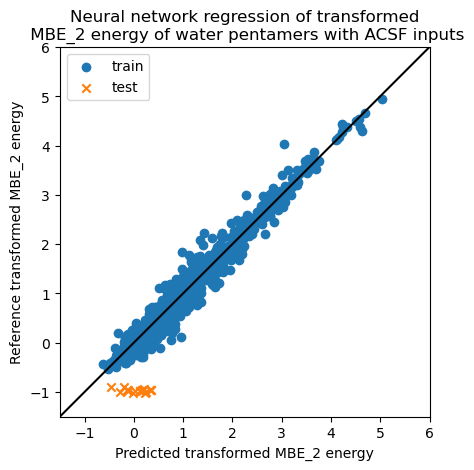

In [53]:
# Show the training and testing results

import matplotlib.pyplot as plt

trans_e_pred_1000_train = []

for struc in strucs_G_train_1000:
    trans_e_pred_1000_train.append(mymodel.forward(struc).detach())
    
trans_e_pred_1000_train = np.asarray(trans_e_pred_1000_train)

trans_e_pred_test = []

for struc in strucs_G_test:
    trans_e_pred_test.append(mymodel.forward(struc).detach())
    
trans_e_pred_test = np.asarray(trans_e_pred_test)
# trans_e_pred_test = mymodel.forward(strucs_G_test)

# print(trans_e_pred_test.size(),trans_e_test.size())

# sys.exit()

# plt.scatter(trans_e_pred_100_train.detach().cpu().numpy(), trans_e_100_train, marker = "o", label = "train")
plt.scatter(trans_e_pred_1000_train, trans_mbe2_1000_train, marker = "o", label = "train")
# plt.scatter(trans_e_pred_test.detach().cpu().numpy(), trans_e_test, marker = "x", label = "test")
plt.scatter(trans_e_pred_test, trans_mbe2_1000_test, marker = "x", label = "test")
plt.plot(np.arange(-2.5,8.0), np.arange(-2.5,8.0), color = "black") # the digonal line for reference
plt.xlabel("Predicted transformed MBE_2 energy")
plt.ylabel("Reference transformed MBE_2 energy")
plt.legend()
plt.title("Neural network regression of transformed\n MBE_2 energy of water pentamers with ACSF inputs")
ax = plt.gca() #you first need to get the axis handle
ax.set_aspect(1.0)
ax.set_xlim([-1.5, 6.0])
ax.set_ylim([-1.5, 6.0])

plt.show()

In [21]:
trans_mbe2_1000_train

tensor([ 1.8894e-01, -1.7137e-02,  2.0911e+00,  2.4555e+00,  6.9120e-01,
         2.1008e+00,  1.6987e+00,  2.7840e+00, -8.6275e-02,  3.6054e-01,
         1.1485e+00,  7.3697e-01,  2.4878e+00,  2.0418e-01,  1.2033e-02,
         7.0773e-01,  1.5525e+00,  1.1409e+00,  9.7679e-02,  2.7081e+00,
        -6.9849e-02, -7.1218e-02,  7.2110e-01, -4.7376e-01,  1.0603e+00,
        -3.7607e-01,  2.8800e-01,  1.6692e+00, -2.3428e-01,  7.1369e-01,
         7.4400e-01,  1.9443e+00,  3.5216e+00,  2.1565e+00,  4.6983e-01,
        -1.8241e-01,  1.0815e+00,  2.9506e-01,  1.4757e+00,  5.4049e-01,
         3.4956e-01,  3.8224e-01,  4.2986e-01,  8.3122e-01,  5.6706e-01,
        -7.8160e-02,  9.0119e-01, -9.1969e-02,  1.1645e+00,  3.8585e-01,
        -4.1738e-02,  7.0716e-02, -1.4496e-01, -3.4945e-01,  1.3027e-01,
         2.9668e+00,  2.6763e+00,  1.7099e+00,  1.6692e-01,  5.1033e-01,
        -3.1980e-01,  1.4269e+00,  6.0158e-01,  1.1582e-01,  1.4129e+00,
        -4.6982e-01,  1.6573e-01,  1.2076e+00, -3.8

In [16]:
trans_e_pred_1000_train

array([[3821.23257065],
       [3821.23257065],
       [3821.23257065],
       [3821.23257065],
       [3821.23257065],
       [3821.23257065],
       [3821.23257065],
       [3821.23257065],
       [3821.23257065],
       [3821.23257065],
       [3821.23257065],
       [3821.23257065],
       [3821.23257065],
       [3821.23257065],
       [3821.23257065],
       [3821.23257065],
       [3821.23257065],
       [3821.23257065],
       [3821.23257065],
       [3821.23257065],
       [3821.23257065],
       [3821.23257065],
       [3821.23257065],
       [3821.23257065],
       [3821.23257065],
       [3821.23257065],
       [3821.23257065],
       [3821.23257065],
       [3821.23257065],
       [3821.23257065],
       [3821.23257065],
       [3821.23257065],
       [3821.23257065],
       [3821.23257065],
       [3821.23257065],
       [3821.23257065],
       [3821.23257065],
       [3821.23257065],
       [3821.23257065],
       [3821.23257065],
       [3821.23257065],
       [3821.232